In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import seaborn as sns
from json import load
import tifffile
from tqdm import tqdm
from matplotlib import rcParams
import glasbey

palette = {
    "green": "#558150",
    "beige": "#F1E2C3",
    "brown": "#A7785A",
    "pink": "#F0D6C2",
    "black": "#0E0E0E",
}

rcParams['font.family'] = 'sans-serif'
rcParams['figure.facecolor'] = "#FFFFFF00"
rcParams['axes.facecolor'] = "#FFFFFF00"
rcParams['legend.framealpha'] = 0.2
rcParams['axes.edgecolor'] = palette["black"]
rcParams['axes.labelcolor'] = palette["black"]
rcParams['xtick.color'] = palette["black"]
rcParams['ytick.color'] = palette["black"]
rcParams['text.color'] = palette["black"]
rcParams['axes.titlecolor'] = palette["black"]

s_palette = sns.cubehelix_palette(as_cmap=True)

In [30]:
from src.utils.tracklets import import_tracklets

roots = ["tll_embryo002a"]
datapath = Path().cwd().parent / "data" / "interim" / "confocal"
plotpath = datapath / "ms2_plots"
plotpath.mkdir(exist_ok=True)

spots, tracklets, metadatas, tracklets_joined = import_tracklets(datapath, roots)
for root in roots:
    spots[root]["e_id"] = [f"{root}_{idx}" for idx in spots[root].ID]
    spots[root]["e_parent_id"] = [f"{root}_{idx}" for idx in spots[root].parent_id]
    spots[root]["e_track_id"] = [f"{root}_{idx}" for idx in spots[root].track_id]
    spots[root]["e_tracklet_id"] = [f"{root}_{idx}" for idx in spots[root].tracklet_id]
    spots[root]["embryo"] = root
    spots[root]["d_poles"] = 0.5 - np.abs(spots[root].ap_position - 0.5)
    
    for categorical_col in ["e_id", "e_parent_id", "e_track_id", "e_tracklet_id", "embryo", "track_id", "tracklet_id"]:
        spots[root][categorical_col] = pd.Categorical(spots[root][categorical_col])
    
spots_joined = pd.concat(spots.values(), ignore_index=True)
spots_joined.set_index("e_id", inplace=True)
spots_joined["e_id"] = spots_joined.index
print(spots_joined.columns)
print(tracklets_joined.columns)

Index(['Unnamed: 0', 'ID', 'track_id', 'tracklet_id', 'distance_from_edge',
       'parent_id', 'daughter_id', 'roi', 'FRAME', 'POSITION_X', 'POSITION_Y',
       'POSITION_Z', 'ELLIPSE_MAJOR', 'ELLIPSE_MINOR', 'ELLIPSE_THETA',
       'ELLIPSE_Y0', 'ELLIPSE_X0', 'ELLIPSE_ASPECTRATIO', 'CIRCULARITY',
       'AREA', 'SHAPE_INDEX', 'MEDIAN_INTENSITY_CH1', 'time', 'um_from_edge',
       'um_x', 'um_y', 'ap_position', 'edge_position', 'track_n_tracklets',
       'cycle', 'e_parent_id', 'e_track_id', 'e_tracklet_id', 'embryo',
       'd_poles', 'e_id'],
      dtype='object')
Index(['start_time', 'end_time', 'start_frame', 'end_frame', 'length',
       'source_spot', 'sink_spot', 'mean_ap_position', 'source_ap_position',
       'sink_ap_position', 'initial_x', 'initial_y', 'final_x', 'final_y',
       'track_id', 'mean_edge_distance', 'track_n_tracklets', 'cycle',
       'embryo', 'tracklet_id', 'parent_tracklet', 'n_children',
       'e_parent_id'],
      dtype='object')


In [4]:
rawpath = datapath / "tll_embryo002a" / "tll_embryo002a_rot_ms2_bgs_Probabilities.tif"
lineages_path = datapath / "tll_embryo002a" / "tll_embryo002a_lineages.tif"
raw = tifffile.imread(rawpath)
lineages = tifffile.imread(lineages_path)
print(lineages.shape)
print(raw.shape)

(115, 768, 1770)
(115, 768, 1770)


In [5]:
from collections import defaultdict
from skimage.draw import polygon
import ast
df_dict = defaultdict(list)

def make_lineage_tif(spots_df: pd.DataFrame, h=1360, w=1360) -> np.ndarray:
    shape = (round(spots_df["FRAME"].max()) + 1, h, w)
    output_tif = np.zeros(shape, dtype=np.uint32)

    for i, spot in tqdm(spots_df.iterrows()):
        x, y = spot["POSITION_X"], spot["POSITION_Y"]
        t = round(spot["FRAME"])
        new_track_id = spot["ID"]
        
        roi = ast.literal_eval(spot["roi"])

        xs = [round(float(pt) + x) for pt in roi[::2]]
        ys = [round(float(pt) + y) for pt in roi[1::2]]

        rr, cc = polygon(ys, xs, shape[1:])
        output_tif[t, rr, cc] = new_track_id

    return output_tif

lineages_tif = make_lineage_tif(spots_joined, h=metadatas[roots[0]]["h"], w=metadatas[roots[0]]["w"])
    

104539it [00:32, 3264.91it/s]


In [6]:
tifffile.imwrite(datapath / "tll_embryo002a" / "tll_embryo002a_spots.tif", lineages_tif)

In [31]:
from skimage.measure import regionprops_table

def fraction_positive(region, intensity_image):
    return np.sum((intensity_image < 128) * region) / np.sum(region)

df = pd.DataFrame(regionprops_table(lineages_tif, intensity_image=raw[:, :, :], properties=["label", "area", "mean_intensity", "max_intensity", "min_intensity", "centroid"], extra_properties=[fraction_positive]))

In [32]:
df["positive"] = df["fraction_positive"] > 0.025

<Axes: xlabel='centroid-0', ylabel='centroid-2'>

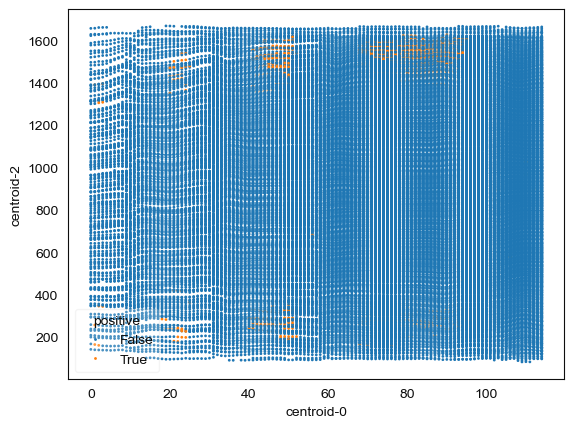

In [33]:
sns.scatterplot(df, x="centroid-0", y="centroid-2", hue="positive", s=4, linewidths=0)

In [34]:
spots_joined["tll"] = spots_joined["ID"].map(df.groupby("label")["positive"].first())

<Axes: xlabel='FRAME', ylabel='tll'>

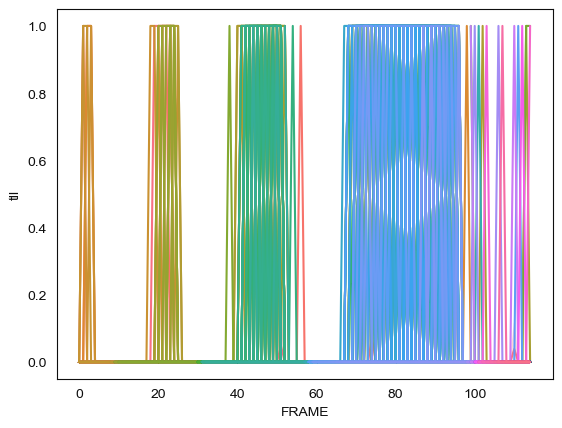

In [35]:
sns.lineplot(spots_joined, x="FRAME", y="tll", hue="tracklet_id", legend=False)

In [40]:
# cycle_13_tracklets = tracklets_joined[tracklets_joined["cycle"] == 13]

def tracklet_ancestry(e_tracklet_id):
    tracklet = tracklets_joined.loc[e_tracklet_id]
    if tracklet["parent_tracklet"] == -1:
        return [e_tracklet_id]
    else:
        return [e_tracklet_id] + tracklet_ancestry(tracklet["e_parent_id"])
    
for tracklet in tracklets_joined.index:
    tracklets_joined.at[tracklet, "ancestry"] = tracklet_ancestry(tracklet)

In [44]:
cycle_13_tracklets = tracklets_joined[tracklets_joined["cycle"] == 13]

tas = dict()  # tracklet ancestry spots

for tracklet in cycle_13_tracklets.index:
    tas[tracklet] = spots_joined[spots_joined["e_tracklet_id"].isin(tracklets_joined.loc[tracklet]["ancestry"])].sort_values("FRAME")

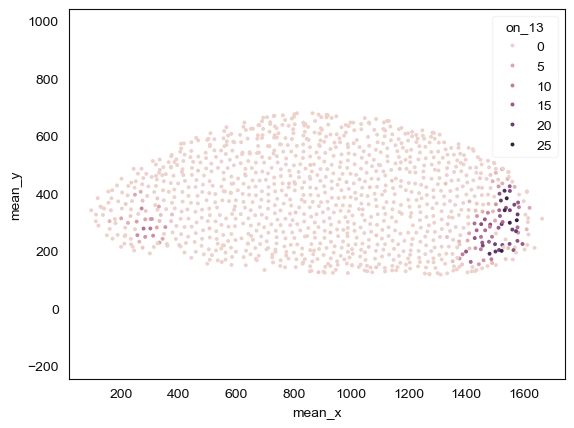

In [59]:
stats = defaultdict(list)

for tracklet, spots_df in tas.items():
    stats["tracklet"].append(tracklet)
    stats["n_spots"].append(len(spots_df))
    stats["time_on"].append(spots_df["tll"].sum())
    stats["time_off"].append(len(spots_df) - spots_df["tll"].sum())
    stats["mean_tll"].append(spots_df["tll"].mean())
    stats["mean_x"].append(spots_df["POSITION_X"].iloc[-1])
    stats["mean_y"].append(spots_df["POSITION_Y"].iloc[-1])
    stats["on_11"].append(spots_df.groupby("cycle")["tll"].sum().get(11, 0))
    stats["on_12"].append(spots_df.groupby("cycle")["tll"].sum().get(12, 0))
    stats["on_13"].append(spots_df.groupby("cycle")["tll"].sum().get(13, 0))

stats_df = pd.DataFrame(stats)

fig, ax = plt.subplots()
sns.scatterplot(stats_df, x="mean_x", y="mean_y", hue="on_13", s=8, linewidths=0)
# set x y ratio
ax.set_aspect('equal', adjustable='datalim')

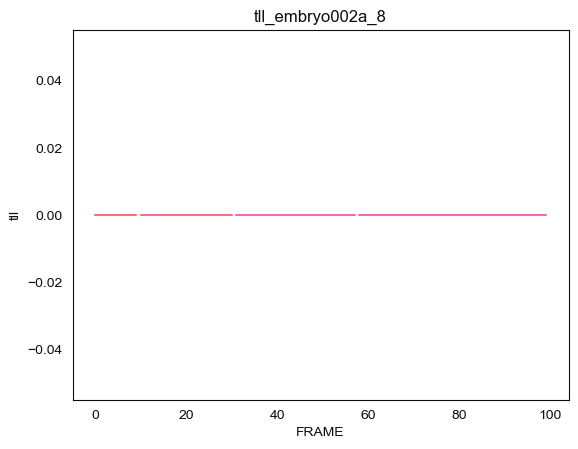

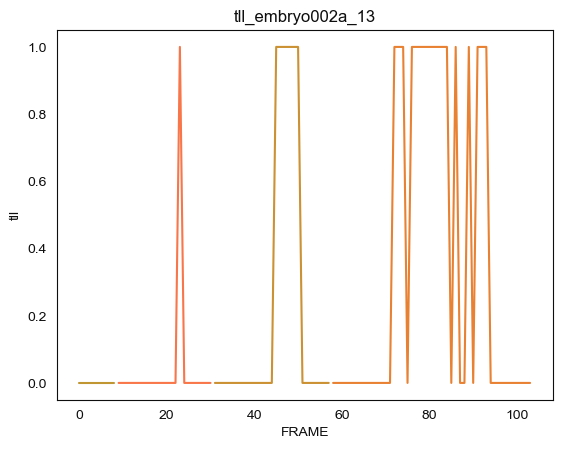

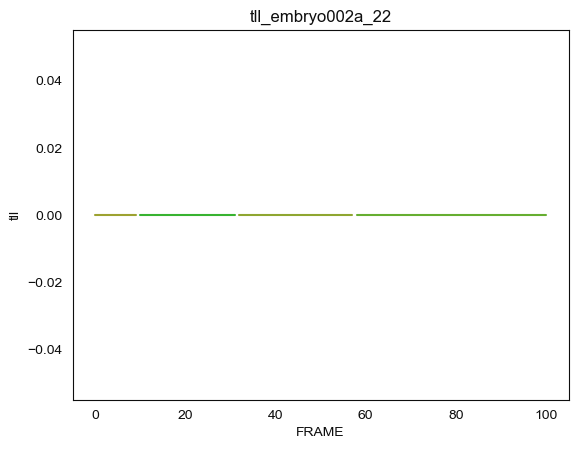

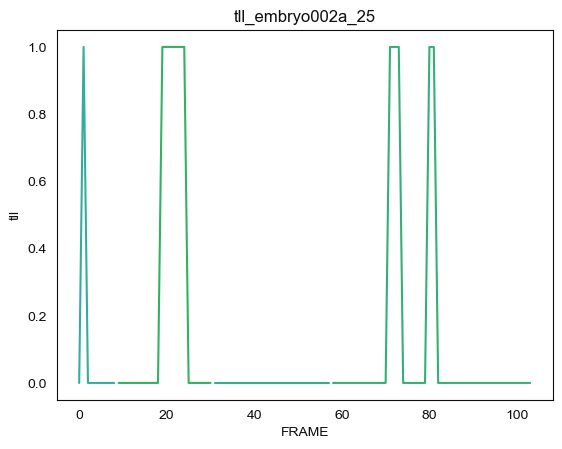

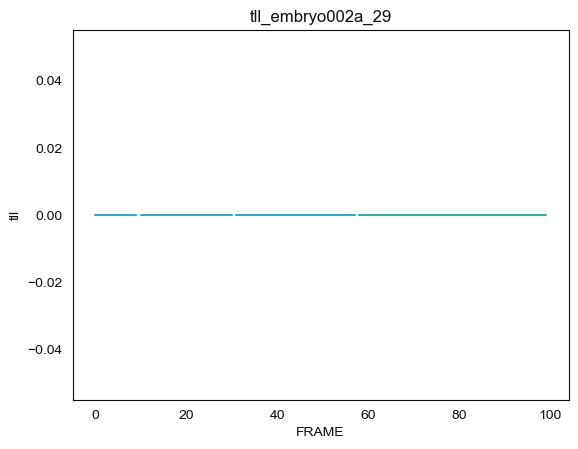

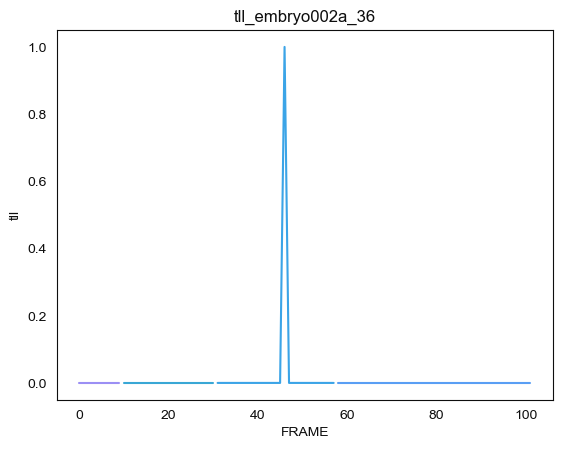

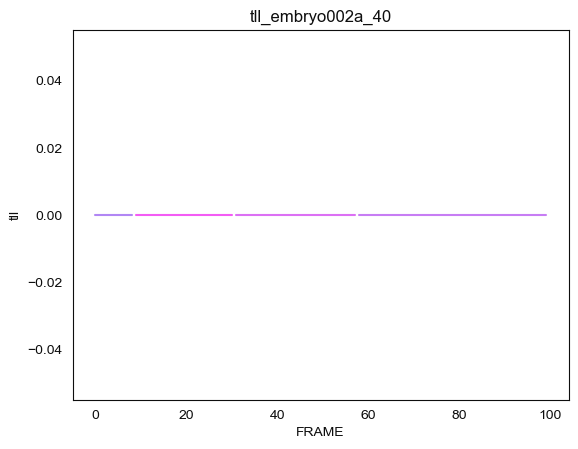

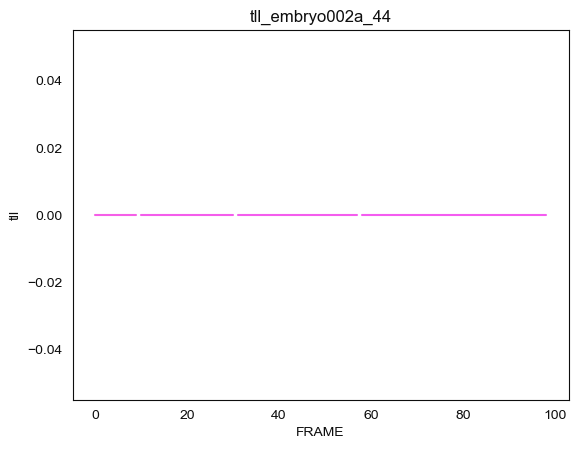

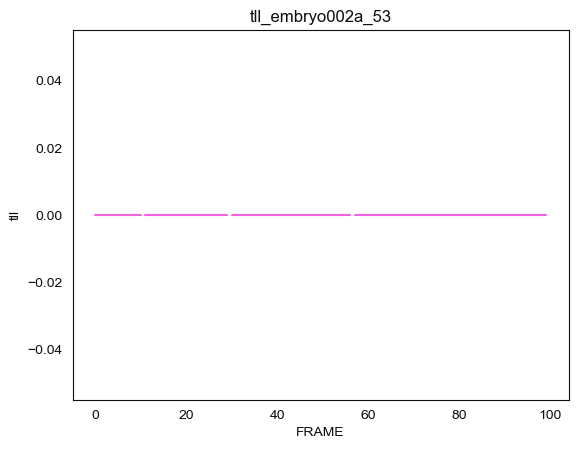

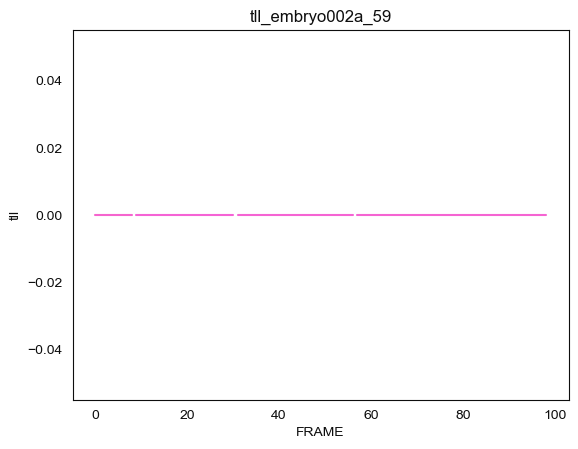

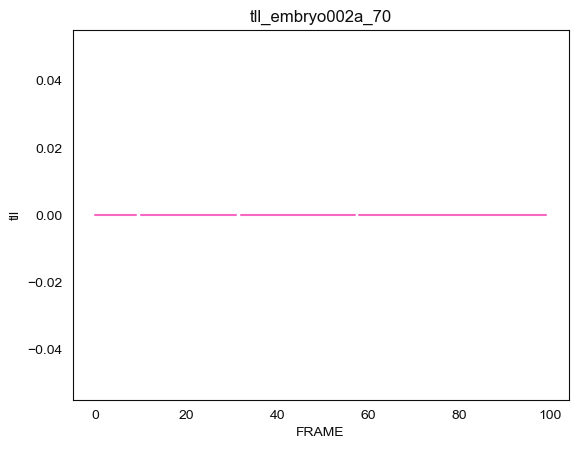

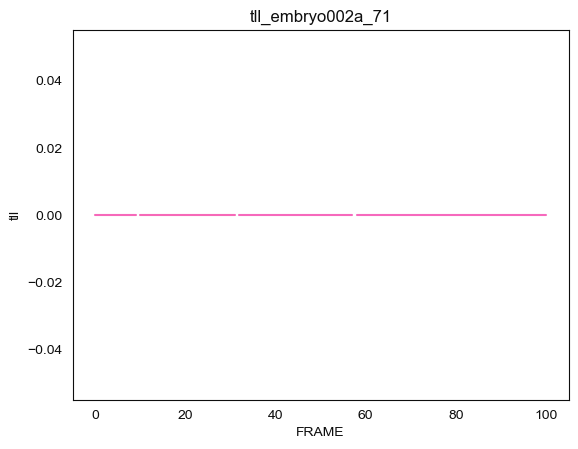

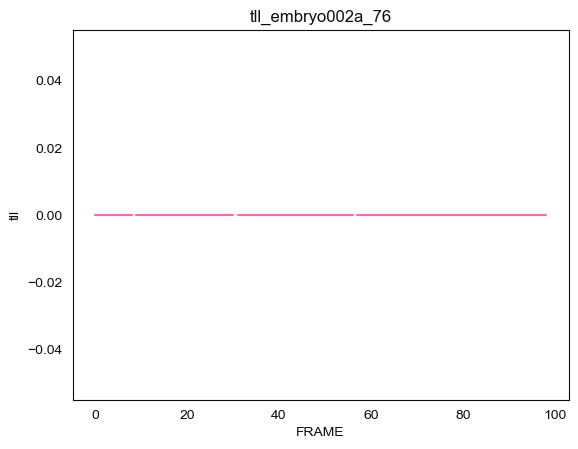

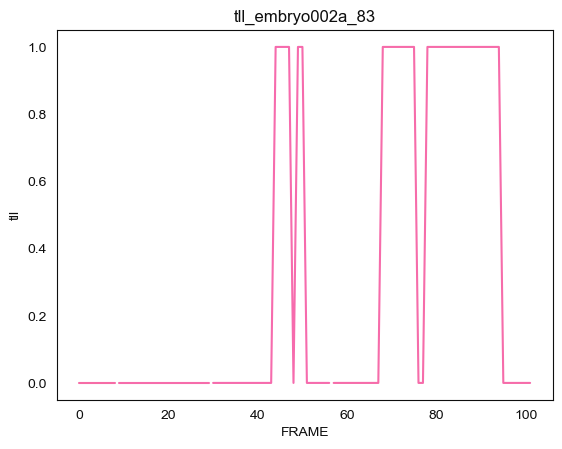

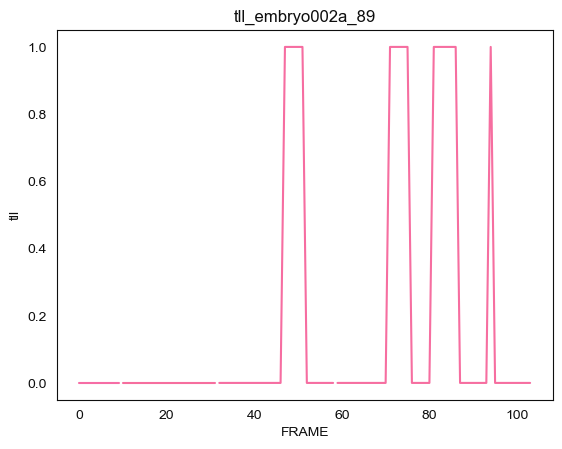

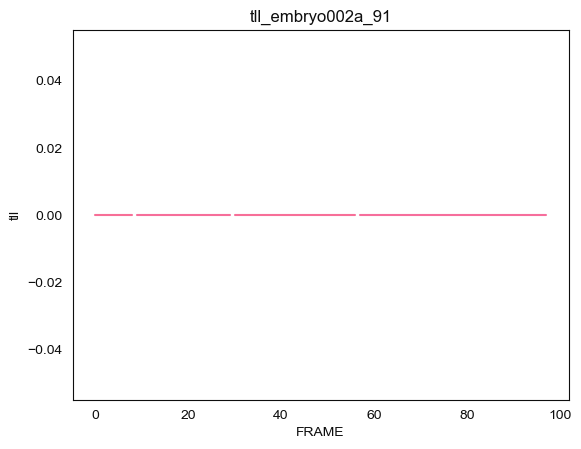

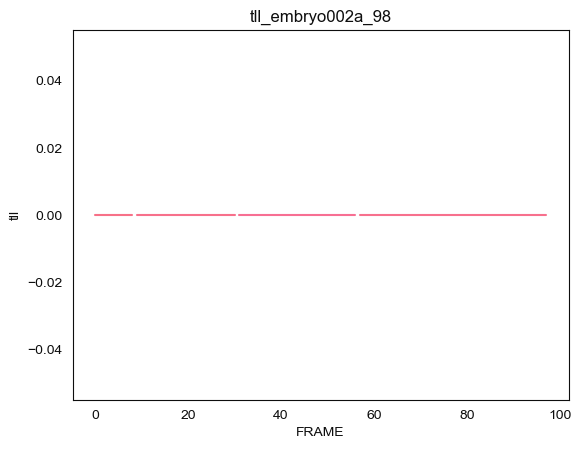

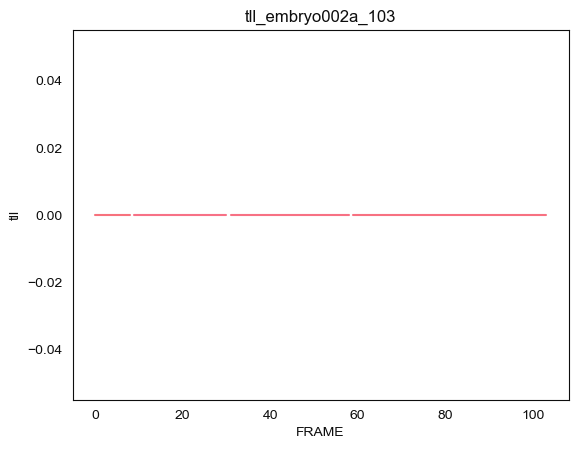

KeyboardInterrupt: 

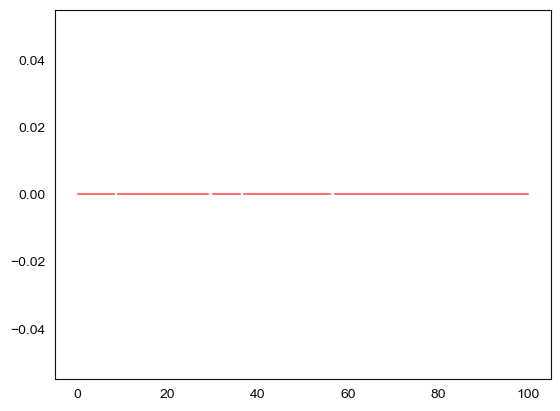

In [45]:
for tracklet, spots_df in tas.items():
    fig, ax = plt.subplots()
    sns.lineplot(spots_df, x="FRAME", y="tll", hue="e_tracklet_id", legend=False, ax=ax)
    ax.set_title(tracklet)
    plt.show()